(ONGOING and UNFINISHED) In this notebook, I'll fit and evaluate a simple one-layer KAN to the Delaney Aqueous Solubility dataset, and then investigate feature importance and the shape of activation functions.

In [248]:
# for imports
import sys
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
import warnings

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list, get_scaffolds

# KAN imports
from kan import KAN

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [249]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [250]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_pandas=True)

Calculating descriptors: 100%|██████████| 1144/1144 [00:05<00:00, 217.04it/s]


In [251]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [252]:
# extract X and y from dataframes
X = descriptors_df.copy()
y = df_delaney['measured log(solubility:mol/L)'].values

X.shape, y.shape

((1144, 217), (1144,))

In [253]:
# split data into training and testing sets
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, y, test_size=test_size, random_state=1738)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((915, 217), (229, 217), (915,), (229,))

In [264]:
# split data into training and testing sets using a scaffold split
scaffolds = get_scaffolds(smiles_list)

test_size = 0.2

splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=1738)

train_idx, test_idx = next(splitter.split(descriptors_df, y, groups=scaffolds))

X_train, X_test = descriptors_df.iloc[train_idx], descriptors_df.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((940, 217), (204, 217), (940,), (204,))

In [265]:
# get the actual train/test proportions
X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]), X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])

(0.8216783216783217, 0.17832167832167833)

In [266]:
selector = VarianceThreshold(threshold = 1e-6)

X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

selector.get_feature_names_out()

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5'

In [267]:
# get the names of the features that were removed
removed_features = [name for name in selector.feature_names_in_ if name not in selector.get_feature_names_out()]
removed_features

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_Al_COO',
 'fr_Ar_COO',
 'fr_COO',
 'fr_COO2',
 'fr_HOCCN',
 'fr_amidine',
 'fr_azide',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_prisulfonamd',
 'fr_quatN',
 'fr_tetrazole',
 'fr_thiocyan']

In [268]:
# standardize features
scaler = StandardScaler()

# fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [269]:
# convert to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [270]:
# make sure it's standardized correctly
assert torch.allclose(X_train_scaled.mean(axis=0), torch.zeros(X_train.shape[1]), atol=1e-6) \
and \
torch.allclose(X_train_scaled.std(axis=0), torch.ones(X_train.shape[1]), atol=0.01)

Text(0, 0.5, 'Standard Deviation')

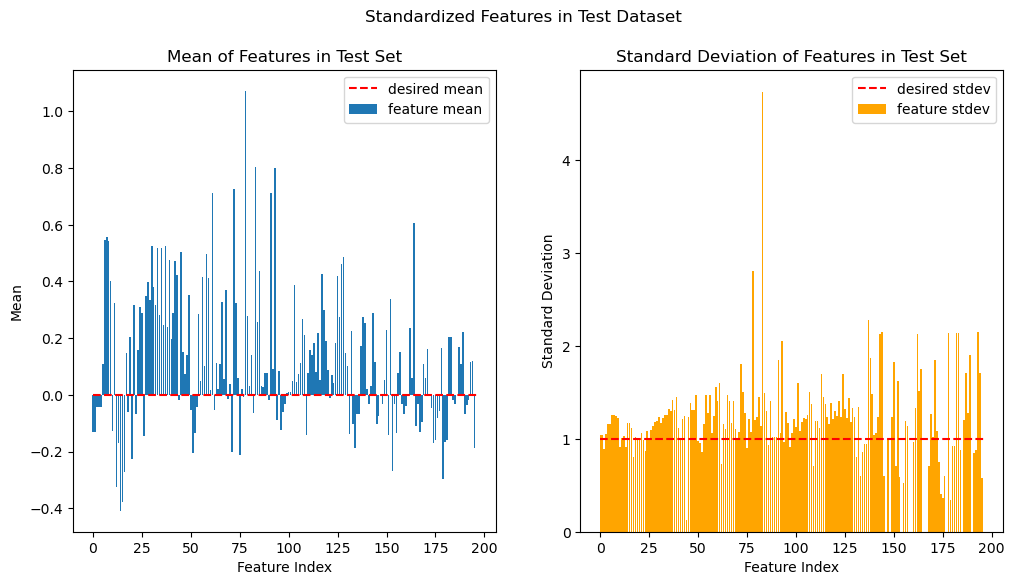

In [271]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

fig.suptitle('Standardized Features in Test Dataset')

# bar chart of means
ax[0].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.mean(axis=0))

ax[0].hlines(y=0, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[0].legend(['desired mean', 'feature mean'])

ax[0].set_title('Mean of Features in Test Set')

ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Mean')


# bar chart of standard deviations
ax[1].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.std(axis=0), color='orange')

ax[1].hlines(y=1, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[1].legend(['desired stdev', 'feature stdev'])  

ax[1].set_title('Standard Deviation of Features in Test Set')

ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Standard Deviation')

# Train Full Model (one-layer KAN)

In [272]:
# instantiate model
num_features = X_train_scaled.shape[1]

torch.manual_seed(1738) 

full_model = KAN(width=[num_features, 1])

checkpoint directory created: ./model
saving model version 0.0


In [273]:
full_model

MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [274]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(full_model.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses = torch.zeros(size=(num_itrs,))
test_mses = torch.zeros(size=(num_itrs,))

train_r2s = torch.zeros(size=(num_itrs,))
test_r2s = torch.zeros(size=(num_itrs,))

train_maes = torch.zeros(size=(num_itrs,))
test_maes = torch.zeros(size=(num_itrs,))

train_rmses = torch.zeros(size=(num_itrs,))
test_rmses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = full_model(X_train_scaled)[:, 0]

    train_mse = F.mse_loss(y_hat_train, y_train)
    train_mae = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse = torch.sqrt(train_mse.detach())
    train_r2 = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse.requires_grad and y_hat_train.requires_grad
    assert not train_mae.requires_grad and not train_rmse.requires_grad and not train_r2.requires_grad
    
    train_mse.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses[i] = train_mse.detach()
    train_maes[i] = train_mae
    train_rmses[i] = train_rmse
    train_r2s[i] = train_r2

    # test
    y_hat_test = full_model(X_test_scaled).detach()[:, 0]

    test_mse = F.mse_loss(y_hat_test, y_test)
    test_mae_loss = F.l1_loss(y_hat_test, y_test)
    test_rmse_loss = torch.sqrt(test_mse)
    test_r2 = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses[i] = test_mse
    test_maes[i] = test_mae_loss
    test_rmses[i] = test_rmse_loss
    test_r2s[i] = test_r2

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse.item()}, r2: {train_r2.item()}, mae: {train_mae.item()}, rmse: {train_rmse.item()}')
        print(f'test iteration {i}, mse: {test_mse.item()}, r2: {test_r2.item()}, mae: {test_mae_loss.item()}, rmse: {test_rmse_loss.item()}')

train iteration 0, mse: 12.58808708190918, r2: -2.3231117725372314, mae: 2.9779727458953857, rmse: 3.547969341278076
test iteration 0, mse: 15.739923477172852, r2: -1.5681672096252441, mae: 3.356586456298828, rmse: 3.9673571586608887
train iteration 50, mse: 0.47243309020996094, r2: 0.8752830624580383, mae: 0.5283825993537903, rmse: 0.6873376965522766
test iteration 50, mse: 1.0094945430755615, r2: 0.8352882266044617, mae: 0.7412518262863159, rmse: 1.004736065864563
train iteration 100, mse: 0.3134344518184662, r2: 0.9172568917274475, mae: 0.4259149432182312, rmse: 0.5598521828651428
test iteration 100, mse: 0.7588038444519043, r2: 0.8761915564537048, mae: 0.631585955619812, rmse: 0.8710934519767761
train iteration 150, mse: 0.24615637958049774, r2: 0.9350175261497498, mae: 0.3765157461166382, rmse: 0.4961414933204651
test iteration 150, mse: 0.6951020956039429, r2: 0.8865853548049927, mae: 0.5976040959358215, rmse: 0.8337278366088867
train iteration 200, mse: 0.20837818086147308, r2: 

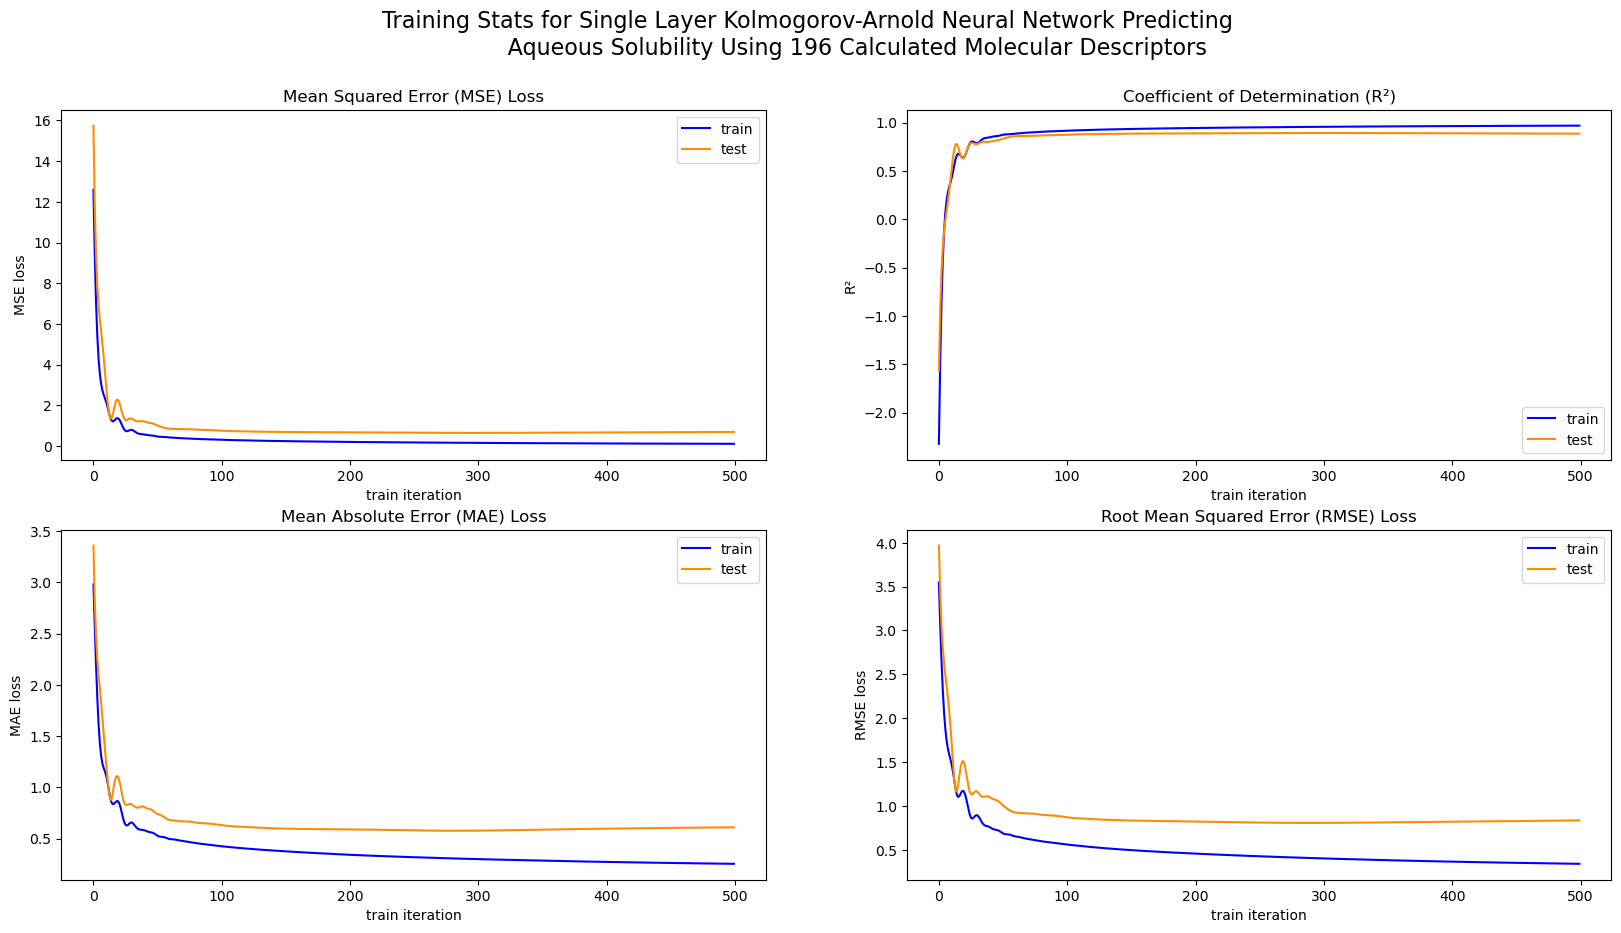

In [275]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting 
             Aqueous Solubility Using {X_train_scaled.shape[1]} Calculated Molecular Descriptors''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train', 'test'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train', 'test'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train', 'test'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train', 'test'])

# Investigating Activations

In [276]:
# I'm going to do this for the full dataset for now
X_scaled = torch.concat((X_train_scaled, X_test_scaled), axis=0)
X_scaled.shape

torch.Size([1144, 196])

In [277]:
y_hat = full_model(X_scaled)

In [278]:
# making sure I'm accessing the activations correctly
assert torch.allclose(full_model.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), full_model(X_scaled))
# the sum of the activations should be equal to the output of the model

In [279]:
# get the activations
activations = full_model.spline_postacts[0][:, 0, :]
assert activations.shape == X_scaled.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
activations.shape # should be (num_samples, num_features)

torch.Size([1144, 196])

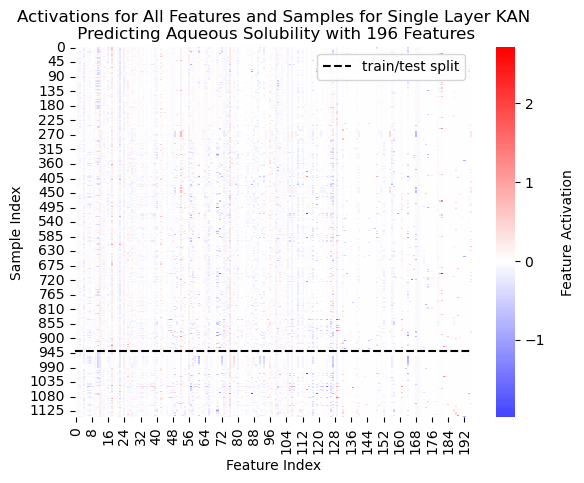

In [280]:
# visualizing all activations for all training samples
sns.heatmap(activations, cmap='bwr', center=0)
plt.title(f'Activations for All Features and Samples for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Features')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')

plt.text(x=240, y=760, s='Feature Activation', color='black', rotation='vertical')

plt.axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='black', linestyle='dashed')
plt.legend(['train/test split'])
plt.show()

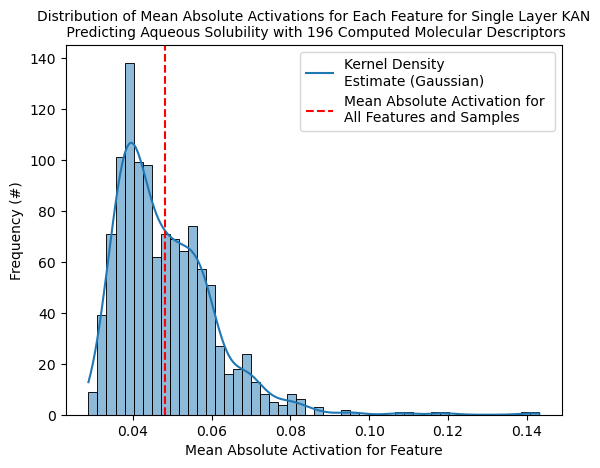

In [281]:
mean_abs_activations = activations.abs().mean(axis=1)
sns.histplot(mean_abs_activations, bins=50, kde=True)
plt.title(f'Distribution of Mean Absolute Activations for Each Feature for Single Layer KAN\n Predicting Aqueous Solubility with {X_scaled.shape[1]} Computed Molecular Descriptors', fontsize=10)
plt.xlabel('Mean Absolute Activation for Feature')
plt.ylabel('Frequency (#)')

plt.axvline(x=mean_abs_activations.mean(), color='r', linestyle='dashed')

plt.legend(['Kernel Density \nEstimate (Gaussian)', 'Mean Absolute Activation for \nAll Features and Samples'])

plt.show()

# Feature Selection Using Pearson Correlation Coefficients

In [282]:
# get the correlation matrix
corrcoefs = torch.corrcoef(X_train_scaled.T)
assert corrcoefs.shape == (X_train_scaled.shape[1], X_train_scaled.shape[1]), 'correlation matrix should be square and have shape (num_features, num_features)'
assert corrcoefs.shape == (selector.get_feature_names_out().shape[0], selector.get_feature_names_out().shape[0]), \
'correlation matrix should have the same number of features as the feature names after variance thresholding feature selection'
corrcoefs.shape

torch.Size([196, 196])

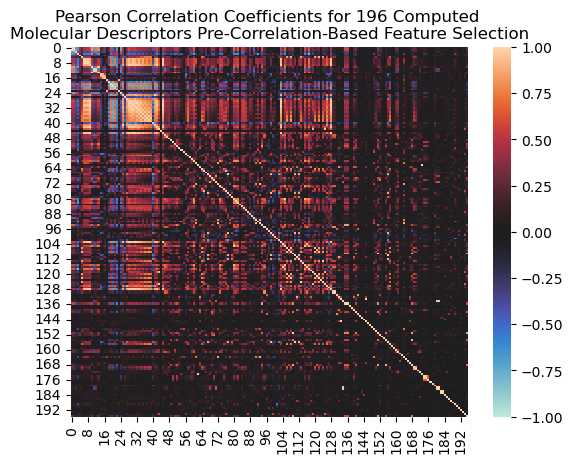

In [283]:
sns.heatmap(corrcoefs, center=0, vmin=-1, vmax=1)
plt.title(f'Pearson Correlation Coefficients for {X_train_scaled.shape[1]} Computed \nMolecular Descriptors Pre-Correlation-Based Feature Selection')
plt.show()

In [284]:
"""
Iterate through the features, keep the first, remove the rest that are highly correlated with it
"""

correlation_threshold = 0.9
retained_feature_idxs = []
removed_feature_idxs = []

corrcoefs_abs = corrcoefs.abs()

for feature_idx, feature_correlations in enumerate(corrcoefs_abs):
    if feature_idx in removed_feature_idxs:
        # if this feature was already removed, skip it
        continue

    else:
        # add the feature itself to the list of retained features
        retained_feature_idxs.append(feature_idx)

        # get the indices of the features that are highly correlated with this feature
        highly_correlated_feature_idxs = torch.where(feature_correlations > correlation_threshold)[0]

        # remove the feature itself
        highly_correlated_feature_idxs = highly_correlated_feature_idxs[highly_correlated_feature_idxs != feature_idx]

        # add the indices of the highly correlated features to the list of removed features
        removed_feature_idxs.extend(highly_correlated_feature_idxs.tolist())
    
# remove duplicates
removed_feature_idxs = list(set(removed_feature_idxs))
retained_feature_idxs = list(set(retained_feature_idxs))

In [285]:
num_features_retained = len(removed_feature_idxs)
num_features_removed = len(retained_feature_idxs)

assert num_features_retained + num_features_removed == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'

print('number of features to remove: ', num_features_removed, \
'\nnumber of features to retain: ', num_features_retained)

number of features to remove:  151 
number of features to retain:  45


In [286]:
# keep track of the names of the features that were retained and removed
features_retained_after_variance_selection = selector.get_feature_names_out()
assert len(features_retained_after_variance_selection) == X_train_scaled.shape[1], 'number of feature names from selector should match number of features in training data'
features_retained_after_correlation_selection = features_retained_after_variance_selection[retained_feature_idxs]
features_removed_after_correlation_selection = features_retained_after_variance_selection[removed_feature_idxs]
assert len(features_retained_after_correlation_selection) + len(features_removed_after_correlation_selection) == X_train_scaled.shape[1], 'number of retained and removed features should sum to total number of features'
# ... yes, I AM that paranoid

print(f'features that were removed via correlation-based selection: \n{features_removed_after_correlation_selection}')

features that were removed via correlation-based selection: 
['MolMR' 'MaxEStateIndex' 'fr_Al_OH_noTert' 'HeavyAtomMolWt' 'ExactMolWt'
 'NumValenceElectrons' 'fr_C_O_noCOO' 'MaxAbsPartialCharge'
 'MinAbsPartialCharge' 'fr_Nhpyrrole' 'BCUT2D_CHGLO' 'fr_amide' 'Chi0'
 'fr_benzene' 'Chi0v' 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi3v' 'Chi4n'
 'Chi4v' 'fr_imide' 'Ipc' 'Kappa1' 'LabuteASA' 'fr_nitrile'
 'fr_nitro_arom' 'fr_phenol' 'fr_phenol_noOrthoHbond' 'fr_phos_ester'
 'SlogP_VSA5' 'SlogP_VSA6' 'VSA_EState10' 'HeavyAtomCount' 'NOCount'
 'NumAliphaticRings' 'NumAromaticCarbocycles' 'NumHAcceptors' 'NumHDonors'
 'NumRotatableBonds' 'NumSaturatedCarbocycles' 'NumSaturatedRings'
 'NumUnspecifiedAtomStereoCenters' 'Phi']


In [287]:
# filter the training and testing data to only include the retained features
X_train_scaled_corr_filtered = X_train_scaled[:, retained_feature_idxs]
X_test_scaled_corr_filtered = X_test_scaled[:, retained_feature_idxs]

X_train_scaled_corr_filtered.shape, X_test_scaled_corr_filtered.shape

(torch.Size([940, 151]), torch.Size([204, 151]))

In [288]:
# make sure correlaton coefficient based feature selection worked
assert torch.sum(torch.corrcoef(X_train_scaled_corr_filtered.T).abs() > correlation_threshold) == X_train_scaled_corr_filtered.shape[1], \
'all features should have correlation coefficients below the threshold except with themselves'

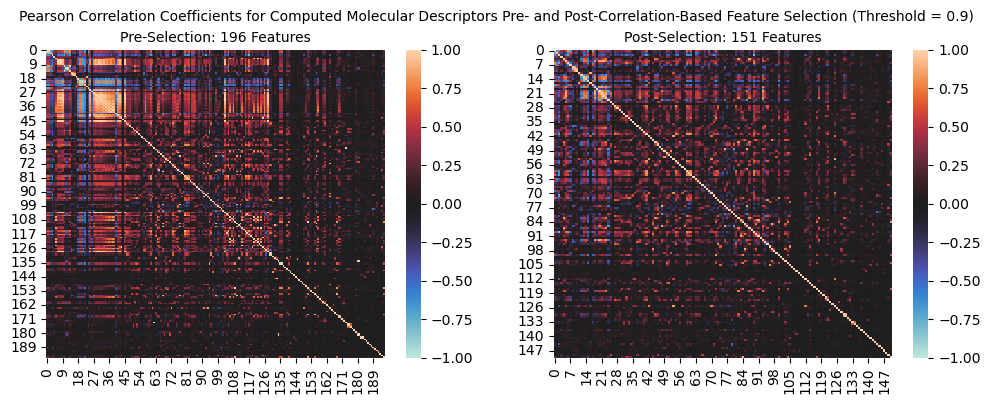

In [289]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.suptitle(f'Pearson Correlation Coefficients for Computed Molecular Descriptors Pre- and Post-Correlation-Based Feature Selection (Threshold = {correlation_threshold})', fontsize=10)

ax[0].set_title(f'Pre-Selection: {X_train_scaled.shape[1]} Features', fontsize=10)
sns.heatmap(data=corrcoefs, ax=ax[0], center=0, vmin=-1, vmax=1)

ax[1].set_title(f'Post-Selection: {X_train_scaled_corr_filtered.shape[1]} Features', fontsize=10)
sns.heatmap(data=torch.corrcoef(X_train_scaled_corr_filtered.T), ax=ax[1], center=0, vmin=-1, vmax=1)
plt.show()

# Train Reduced Model

In [290]:
torch.manual_seed(1738)

model_reduced = KAN(width=[X_train_scaled_corr_filtered.shape[1], 1])

checkpoint directory created: ./model
saving model version 0.0


In [291]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_reduced.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_red = torch.zeros(size=(num_itrs,))
test_mses_red = torch.zeros(size=(num_itrs,))

train_r2s_red = torch.zeros(size=(num_itrs,))
test_r2s_red = torch.zeros(size=(num_itrs,))

train_maes_red = torch.zeros(size=(num_itrs,))
test_maes_red = torch.zeros(size=(num_itrs,))

train_rmses_red = torch.zeros(size=(num_itrs,))
test_rmses_red = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_reduced(X_train_scaled_corr_filtered)[:, 0]

    train_mse_red = F.mse_loss(y_hat_train, y_train)
    train_mae_red = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_red = torch.sqrt(train_mse_red.detach())
    train_r2_red = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_red.requires_grad and y_hat_train.requires_grad
    assert not train_maes_red.requires_grad and not train_rmse_red.requires_grad and not train_r2_red.requires_grad
    
    train_mse_red.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_red[i] = train_mse_red.detach()
    train_maes_red[i] = train_mae_red
    train_rmses_red[i] = train_rmse_red
    train_r2s_red[i] = train_r2_red

    # test
    y_hat_test = model_reduced(X_test_scaled_corr_filtered).detach()[:, 0]

    test_mse_red = F.mse_loss(y_hat_test, y_test)
    test_mae_red = F.l1_loss(y_hat_test, y_test)
    test_rmse_red = torch.sqrt(test_mse_red)
    test_r2_red = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_red[i] = test_mse_red
    test_maes_red[i] = test_mae_red
    test_rmses_red[i] = test_rmse_red
    test_r2s_red[i] = test_r2_red

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_red.item()}, r2: {train_r2_red.item()}, mae: {train_mae_red.item()}, rmse: {train_rmse_red.item()}')
        print(f'test iteration {i}, mse: {test_mse_red.item()}, r2: {test_r2_red.item()}, mae: {test_mae_red.item()}, rmse: {test_rmse_red.item()}')

train iteration 0, mse: 12.305124282836914, r2: -2.248412609100342, mae: 2.896608829498291, rmse: 3.507866144180298
test iteration 0, mse: 20.98080825805664, r2: -2.423283576965332, mae: 3.7821409702301025, rmse: 4.580481052398682
train iteration 50, mse: 0.5145938396453857, r2: 0.8641530871391296, mae: 0.5533822178840637, rmse: 0.7173519730567932
test iteration 50, mse: 1.110127568244934, r2: 0.8188686370849609, mae: 0.7581173181533813, rmse: 1.0536259412765503
train iteration 100, mse: 0.33077627420425415, r2: 0.9126788377761841, mae: 0.44200658798217773, rmse: 0.5751315355300903
test iteration 100, mse: 0.7985586524009705, r2: 0.869705080986023, mae: 0.6374235153198242, rmse: 0.8936210870742798
train iteration 150, mse: 0.26834771037101746, r2: 0.9291592836380005, mae: 0.3934941589832306, rmse: 0.518022894859314
test iteration 150, mse: 0.7115535140037537, r2: 0.883901059627533, mae: 0.6020194888114929, rmse: 0.8435363173484802
train iteration 200, mse: 0.23444408178329468, r2: 0.93

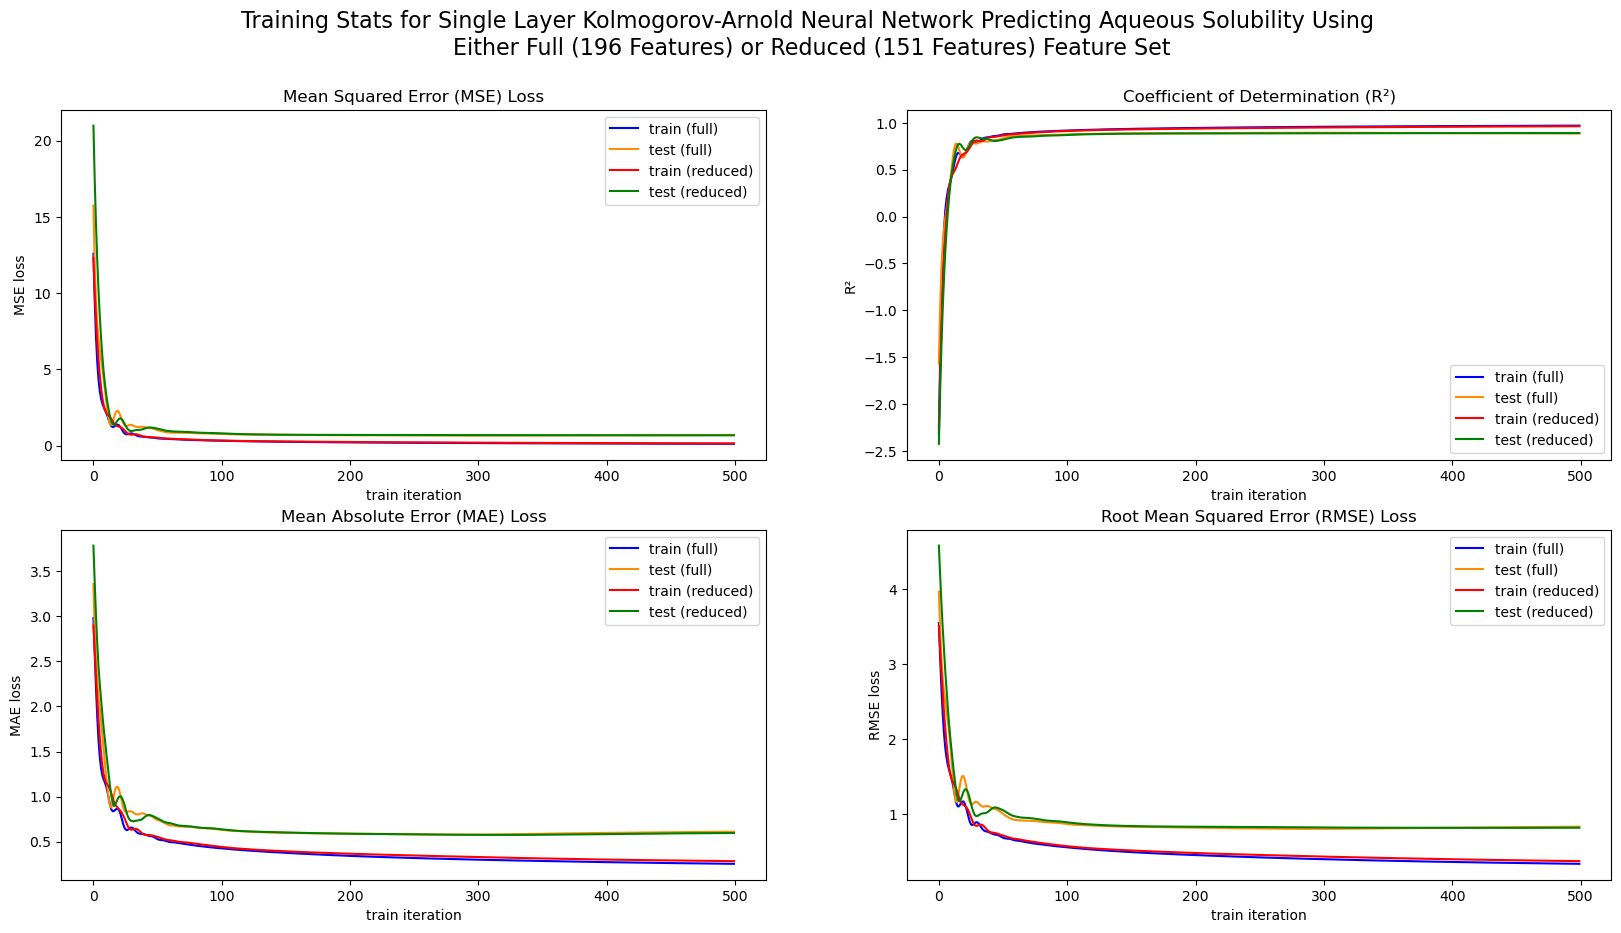

In [292]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nEither Full ({X_train_scaled.shape[1]} Features) or Reduced ({X_train_scaled_corr_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].plot(train_mses_red, c='red')
ax[0, 0].plot(test_mses_red, c='green')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].plot(train_r2s_red, c='red')
ax[0, 1].plot(test_r2s_red, c='green')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].plot(train_maes_red, c='red')
ax[1, 0].plot(test_maes_red, c='green')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].plot(train_rmses_red, c='red')
ax[1, 1].plot(test_rmses_red, c='green')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)'])

# Comparing Activations for Full and Reduced (based on correlations) Models

In [293]:
X_scaled_corr_filtered = torch.concat((X_train_scaled_corr_filtered, X_test_scaled_corr_filtered), axis=0)
X_scaled_corr_filtered.shape

y_hat_red = model_reduced(X_scaled_corr_filtered)

# making sure I'm accessing the activations correctly
assert torch.allclose(model_reduced.spline_postacts[0][:, 0, :].sum(axis=1).unsqueeze(dim=1), model_reduced(X_scaled_corr_filtered))

# get the activations
activations_red = model_reduced.spline_postacts[0][:, 0, :]

# check the activations again because I'm paranoid
assert activations_red.shape == X_scaled_corr_filtered.shape, 'shape of activations should match shape of input data for one-layer KAN (num_samples, num_features)'
assert torch.allclose(activations_red.sum(axis=1).reshape(-1, 1), y_hat_red), 'sum of activations should be equal to the output of the model'

activations_red.shape

torch.Size([1144, 151])

In [294]:
# get the overall max and min of activations for full and reduced models
max_activation_full = activations.max()
min_activation_full = activations.min()
max_activation_red = activations_red.max()
min_activation_red = activations_red.min()
max_activation_overall = max(max_activation_full, max_activation_red)
min_activation_overall = min(min_activation_full, min_activation_red)
max_activation_overall, min_activation_overall

(tensor(2.9379), tensor(-3.2457))

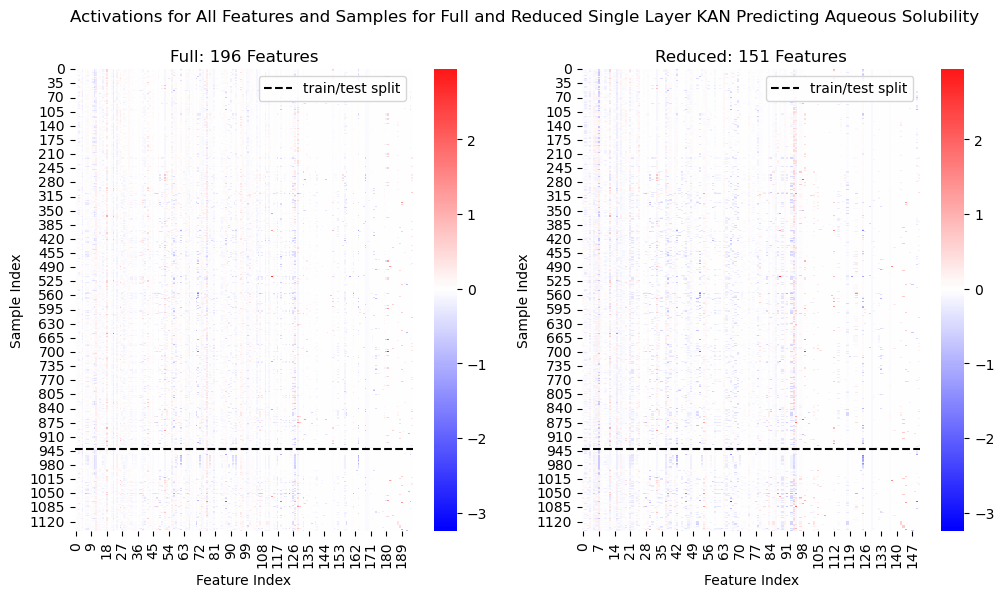

In [295]:
# visually compare activations for full vs reduced model
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

plt.suptitle(f'Activations for All Features and Samples for Full and Reduced Single Layer KAN Predicting Aqueous Solubility', fontsize=12)

# Heatmap for the unreduced model activations
sns.heatmap(activations, cmap='bwr', center=0, ax=ax[0], vmin=min_activation_overall, vmax=max_activation_overall)
ax[0].set_title(f'Full: {X_scaled.shape[1]} Features')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Sample Index')
ax[0].axhline(y=X_train_scaled.shape[0], xmin=0, xmax=X_scaled.shape[1], color='black', linestyle='dashed')
ax[0].legend(['train/test split'])

# Heatmap for the reduced model activations
sns.heatmap(activations_red, cmap='bwr', center=0, ax=ax[1], vmin=min_activation_overall, vmax=max_activation_overall)
ax[1].set_title(f'Reduced: {X_scaled_corr_filtered.shape[1]} Features')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Sample Index')
ax[1].axhline(y=X_train_scaled_corr_filtered.shape[0], xmin=0, xmax=X_scaled_corr_filtered.shape[1], color='black', linestyle='dashed')
ax[1].legend(['train/test split'])

plt.show()

In [296]:
mean_abs_activations_full = activations.abs().mean(axis=1)
mean_abs_activations_red = activations_red.abs().mean(axis=1)

xmin = np.min([mean_abs_activations_full.min().item(), mean_abs_activations_red.min().item()])
xmax = np.max([mean_abs_activations_full.max().item(), mean_abs_activations_red.max().item()])

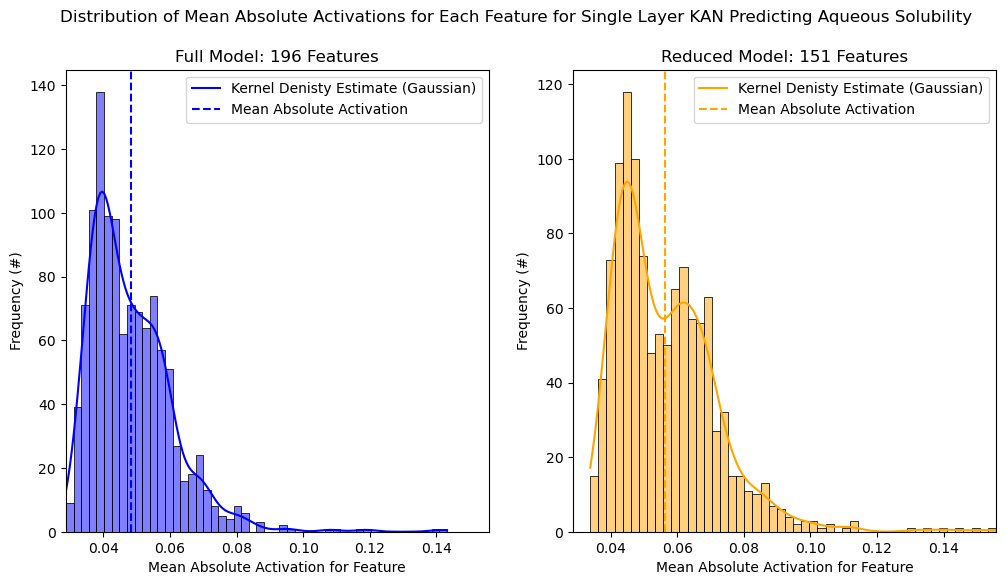

In [297]:
# visually compare distributions of mean absolute activations for full vs reduced model

# assert 1==2, 'set the xlims or whatever so it makes sense to compare them'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Mean absolute activations for full model
sns.histplot(mean_abs_activations_full, bins=50, kde=True, color='blue', ax=ax[0])
ax[0].axvline(x=mean_abs_activations_full.mean(), color='blue', linestyle='dashed')
ax[0].set_title(f'Full Model: {X_scaled.shape[1]} Features')
ax[0].set_xlabel('Mean Absolute Activation for Feature')
ax[0].set_ylabel('Frequency (#)')
ax[0].legend(['Kernel Denisty Estimate (Gaussian)', 'Mean Absolute Activation'])
ax[0].set_xlim(xmin, xmax)

# Mean absolute activations for reduced model
sns.histplot(mean_abs_activations_red, bins=50, kde=True, color='orange', ax=ax[1])
ax[1].axvline(x=mean_abs_activations_red.mean(), color='orange', linestyle='dashed')
ax[1].set_title(f'Reduced Model: {X_scaled_corr_filtered.shape[1]} Features')
ax[1].set_xlabel('Mean Absolute Activation for Feature')
ax[1].set_ylabel('Frequency (#)')
ax[1].legend(['Kernel Denisty Estimate (Gaussian)', 'Mean Absolute Activation'])
ax[1].set_xlim(xmin, xmax)

plt.suptitle('Distribution of Mean Absolute Activations for Each Feature for Single Layer KAN Predicting Aqueous Solubility', fontsize=12)
plt.show()

# Selecting Based on Feature Importances

In [298]:
feature_scores = model_reduced.feature_score.detach()
feature_scores.shape

torch.Size([151])

Text(0.5, 0, 'Feature Score')

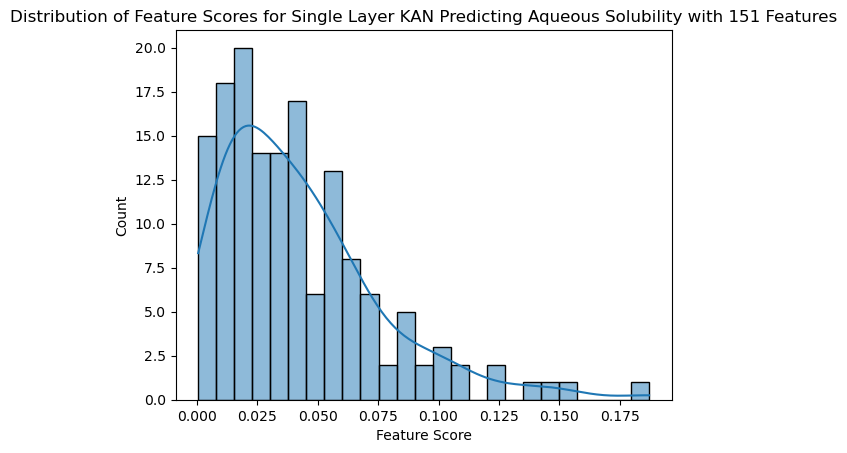

In [299]:
sns.histplot(feature_scores, bins=25, kde=True)
plt.title(f'Distribution of Feature Scores for Single Layer KAN Predicting Aqueous Solubility with {X_scaled_corr_filtered.shape[1]} Features')
plt.xlabel('Feature Score')

In [300]:
feature_score_threshold = 0.125
features_to_keep_idx = torch.nonzero(feature_scores > feature_score_threshold).flatten()

features_retained_after_feature_score_selection = features_retained_after_correlation_selection[features_to_keep_idx]
feature_scores_retained = feature_scores[features_to_keep_idx]

features_to_keep_idx, feature_scores_retained, features_retained_after_feature_score_selection

(tensor([  7,  12,  94, 125]),
 tensor([0.1872, 0.1388, 0.1552, 0.1441]),
 array(['MinPartialCharge', 'BCUT2D_MWLOW', 'MolLogP', 'fr_halogen'],
       dtype=object))

In [301]:
X_train_scaled_feature_score_filtered = X_train_scaled_corr_filtered[:, features_to_keep_idx]
X_test_scaled_feature_score_filtered = X_test_scaled_corr_filtered[:, features_to_keep_idx]

X_train_scaled_feature_score_filtered.shape, X_test_scaled_feature_score_filtered.shape

(torch.Size([940, 4]), torch.Size([204, 4]))

In [302]:
model_fss = KAN(width=[X_train_scaled_feature_score_filtered.shape[1], 1])

checkpoint directory created: ./model
saving model version 0.0


In [303]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_fss.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_fss = torch.zeros(size=(num_itrs,))
test_mses_fss = torch.zeros(size=(num_itrs,))

train_r2s_fss = torch.zeros(size=(num_itrs,))
test_r2s_fss = torch.zeros(size=(num_itrs,))

train_maes_fss = torch.zeros(size=(num_itrs,))
test_maes_fss = torch.zeros(size=(num_itrs,))

train_rmses_fss = torch.zeros(size=(num_itrs,))
test_rmses_fss = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_fss(X_train_scaled_feature_score_filtered)[:, 0]

    train_mse_fss = F.mse_loss(y_hat_train, y_train)
    train_mae_fss = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_fss = torch.sqrt(train_mse_fss.detach())
    train_r2_fss = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_fss.requires_grad and y_hat_train.requires_grad
    assert not train_mae_fss.requires_grad and not train_rmse_fss.requires_grad and not train_r2_fss.requires_grad
    
    train_mse_fss.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_fss[i] = train_mse_fss.detach()
    train_maes_fss[i] = train_mae_fss
    train_rmses_fss[i] = train_rmse_fss
    train_r2s_fss[i] = train_r2_fss

    pre_test_feature_scores = model_fss.feature_score.detach()
    # test
    y_hat_test = model_fss(X_test_scaled_feature_score_filtered).detach()[:, 0]

    post_test_feature_scores = model_fss.feature_score.detach()


    test_mse_fss = F.mse_loss(y_hat_test, y_test)
    test_mae_fss = F.l1_loss(y_hat_test, y_test)
    test_rmse_fss = torch.sqrt(test_mse_fss)
    test_r2_fss = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_fss[i] = test_mse_fss
    test_maes_fss[i] = test_mae_fss
    test_rmses_fss[i] = test_rmse_fss
    test_r2s_fss[i] = test_r2_fss

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_fss.item()}, r2: {train_r2_fss.item()}, mae: {train_mae_fss.item()}, rmse: {train_rmse_fss.item()}')
        print(f'test iteration {i}, mse: {test_mse_fss.item()}, r2: {test_r2_fss.item()}, mae: {test_mae_fss.item()}, rmse: {test_rmse_fss.item()}')

    if not torch.allclose(pre_test_feature_scores, post_test_feature_scores):
        warnings.warn('feature scores should not change during testing')


train iteration 0, mse: 13.82933235168457, r2: -2.6507863998413086, mae: 3.0791077613830566, rmse: 3.718780994415283
test iteration 0, mse: 28.41961097717285, r2: -3.6370182037353516, mae: 4.436656951904297, rmse: 5.331004619598389
train iteration 50, mse: 3.871159553527832, r2: -0.02194201946258545, mae: 1.4992437362670898, rmse: 1.9675261974334717
test iteration 50, mse: 7.826235771179199, r2: -0.2769491672515869, mae: 2.2254276275634766, rmse: 2.7975409030914307


/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_76525/1834969756.py:62: UserWarning: feature scores should not change during testing
  warnings.warn('feature scores should not change during testing')


train iteration 100, mse: 1.605522632598877, r2: 0.5761603116989136, mae: 0.9590619206428528, rmse: 1.267092227935791
test iteration 100, mse: 2.5747389793395996, r2: 0.5798988342285156, mae: 1.251746654510498, rmse: 1.6045993566513062
train iteration 150, mse: 1.1621818542480469, r2: 0.6931972503662109, mae: 0.8210279941558838, rmse: 1.07804536819458
test iteration 150, mse: 1.9838625192642212, r2: 0.6763077974319458, mae: 1.1028419733047485, rmse: 1.4084964990615845
train iteration 200, mse: 1.0382015705108643, r2: 0.7259266376495361, mae: 0.776303231716156, rmse: 1.0189217329025269
test iteration 200, mse: 1.8683828115463257, r2: 0.6951497793197632, mae: 1.0793530941009521, rmse: 1.3668880462646484
train iteration 250, mse: 0.9874466061592102, r2: 0.7393252849578857, mae: 0.7571330666542053, rmse: 0.9937034845352173
test iteration 250, mse: 1.788469672203064, r2: 0.7081885933876038, mae: 1.0602306127548218, rmse: 1.337336778640747
train iteration 300, mse: 0.9552217721939087, r2: 0.

In [304]:
pre_test_feature_scores, post_test_feature_scores

(tensor([0.2051, 0.3006, 0.7725, 0.0976]),
 tensor([0.1654, 0.2148, 0.7151, 0.1274]))

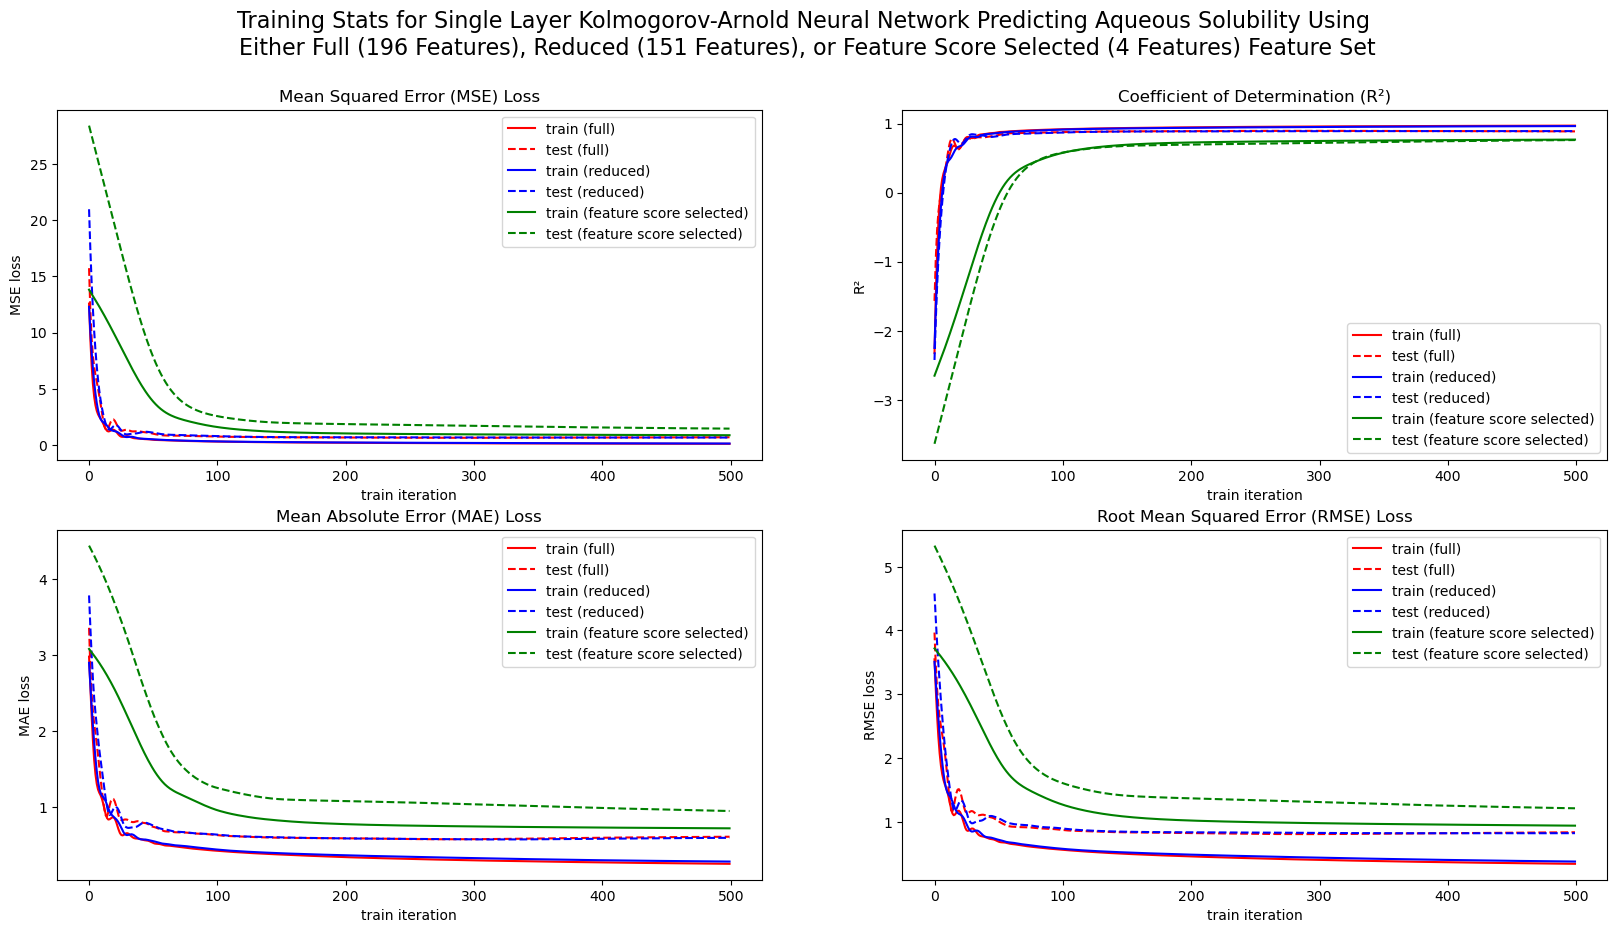

In [305]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nEither Full ({X_train_scaled.shape[1]} Features), Reduced ({X_train_scaled_corr_filtered.shape[1]} Features), or Feature Score Selected ({X_train_scaled_feature_score_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='red', linestyle='-')
ax[0, 0].plot(test_mses, c='red', linestyle='--')
ax[0, 0].plot(train_mses_red, c='blue', linestyle='-')
ax[0, 0].plot(test_mses_red, c='blue', linestyle='--')
ax[0, 0].plot(train_mses_fss, c='green', linestyle='-')
ax[0, 0].plot(test_mses_fss, c='green', linestyle='--')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# r2 plot
ax[0, 1].plot(train_r2s, c='red', linestyle='-')
ax[0, 1].plot(test_r2s, c='red', linestyle='--')
ax[0, 1].plot(train_r2s_red, c='blue', linestyle='-')
ax[0, 1].plot(test_r2s_red, c='blue', linestyle='--')
ax[0, 1].plot(train_r2s_fss, c='green', linestyle='-')
ax[0, 1].plot(test_r2s_fss, c='green', linestyle='--')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# mae plot
ax[1, 0].plot(train_maes, c='red', linestyle='-')
ax[1, 0].plot(test_maes, c='red', linestyle='--')
ax[1, 0].plot(train_maes_red, c='blue', linestyle='-')
ax[1, 0].plot(test_maes_red, c='blue', linestyle='--')
ax[1, 0].plot(train_maes_fss, c='green', linestyle='-')
ax[1, 0].plot(test_maes_fss, c='green', linestyle='--')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

# rmse plot
ax[1, 1].plot(train_rmses, c='red', linestyle='-')
ax[1, 1].plot(test_rmses, c='red', linestyle='--')
ax[1, 1].plot(train_rmses_red, c='blue', linestyle='-')
ax[1, 1].plot(test_rmses_red, c='blue', linestyle='--')
ax[1, 1].plot(train_rmses_fss, c='green', linestyle='-')
ax[1, 1].plot(test_rmses_fss, c='green', linestyle='--')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (full)', 'test (full)', 'train (reduced)', 'test (reduced)', 'train (feature score selected)', 'test (feature score selected)'])

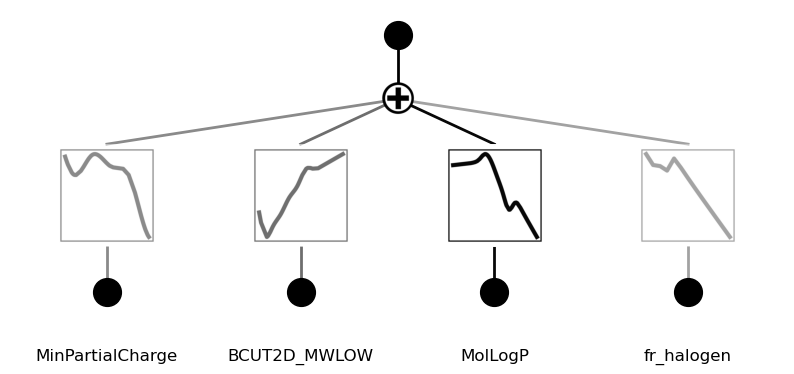

In [306]:
model_fss.plot(in_vars=list(features_retained_after_feature_score_selection), varscale=.3, scale=1)

In [307]:
features_retained_after_feature_score_selection

array(['MinPartialCharge', 'BCUT2D_MWLOW', 'MolLogP', 'fr_halogen'],
      dtype=object)

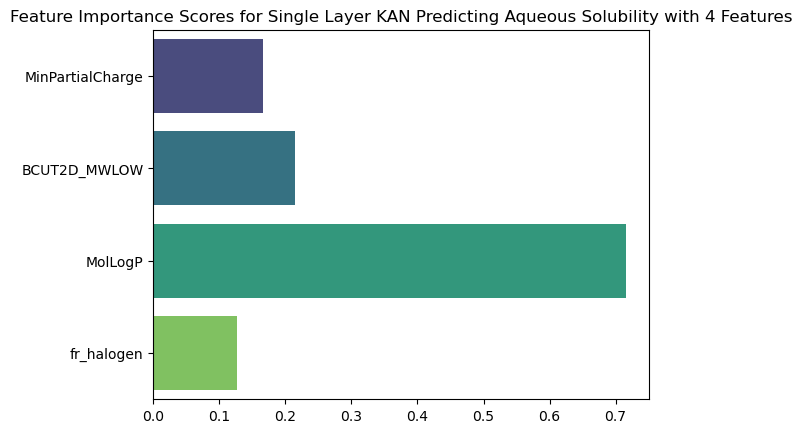

In [308]:
feature_scores = dict(zip(features_retained_after_feature_score_selection, model_fss.feature_score.detach().tolist()))

sns.barplot(x=list(feature_scores.values()), y=list(feature_scores.keys()), orient='h', palette='viridis', hue=list(feature_scores.keys()))

plt.title(f'Feature Importance Scores for Single Layer KAN Predicting Aqueous Solubility with {X_train_scaled_feature_score_filtered.shape[1]} Features')

plt.show()

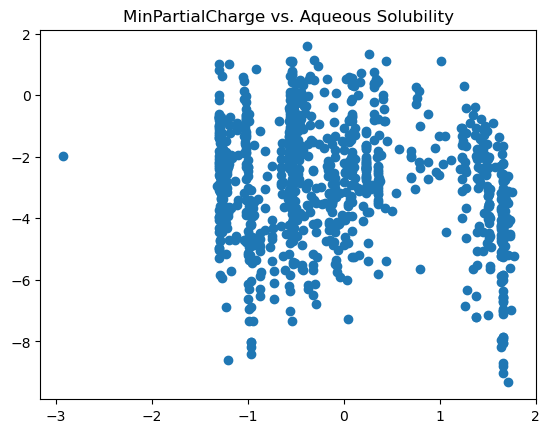

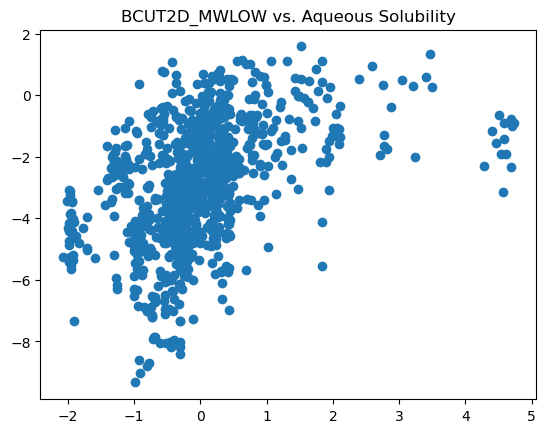

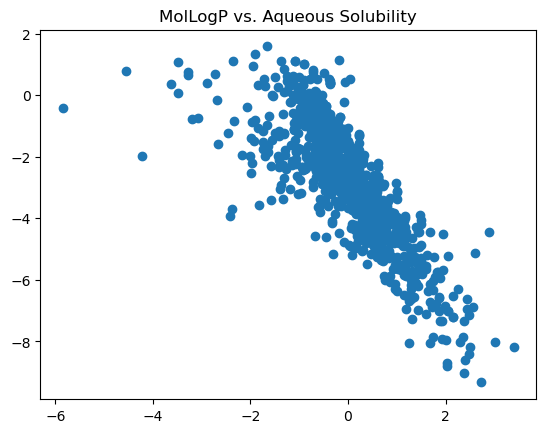

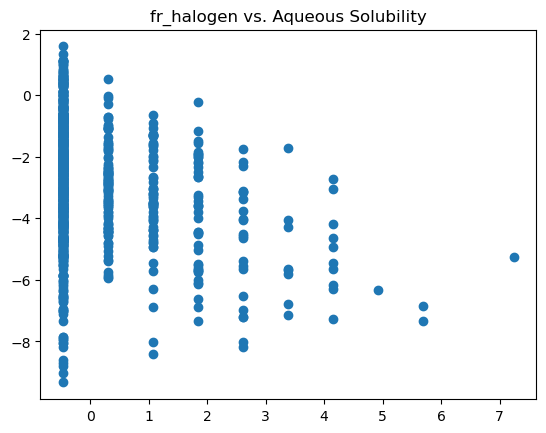

In [309]:
for i, feature in enumerate(X_train_scaled_feature_score_filtered.T):
    plt.scatter(feature, y_train)
    
    plt.title(f'{features_retained_after_feature_score_selection[i]} vs. Aqueous Solubility')
    plt.show()

# Unrelated: Figuring out What BCUT2D is

In [310]:
# making sure BCUT2D_MWLOW is the same as BCUT2D

BCUT2D_MWLOW = descriptors_df['BCUT2D_MWLOW'].values

from rdkit.Chem.rdMolDescriptors import BCUT2D
from rdkit import Chem

BCUT2D = np.array([BCUT2D(Chem.MolFromSmiles(smiles)) for smiles in df_delaney.SMILES])

In [311]:
BCUT2D_features = ["mass eigen value high", "mass eigen value low",
"gasteiger charge eigenvalue high", "gasteiger charge low", "crippen lowgp eigenvalue high", "crippen lowgp low", "crippen mr eigenvalue high", "crippen mr low"]

BCUT2D_features

['mass eigen value high',
 'mass eigen value low',
 'gasteiger charge eigenvalue high',
 'gasteiger charge low',
 'crippen lowgp eigenvalue high',
 'crippen lowgp low',
 'crippen mr eigenvalue high',
 'crippen mr low']

In [312]:
features_match = []

for feature in BCUT2D.T:
    features_match.append(torch.allclose(torch.tensor(feature, dtype=torch.float32), torch.tensor(BCUT2D_MWLOW, dtype=torch.float32)))

features_match

[False, True, False, False, False, False, False, False]

In [313]:
# get the name of the feature in BCUT2D that BCUT2D_MWLOW actually corresponds to
BCUT2D_features[features_match.index(True)]

'mass eigen value low'

# What about more layers?

In [314]:
model_fss_2_layer = KAN(width=[X_train_scaled_feature_score_filtered.shape[1], 2, 1])

checkpoint directory created: ./model
saving model version 0.0


In [315]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model_fss_2_layer.parameters(), lr=lr) # they used LBFGS in the paper but sticking to ADAM for now

train_mses_fss_2_layer = torch.zeros(size=(num_itrs,))
test_mses_fss_2_layer = torch.zeros(size=(num_itrs,))

train_r2s_fss_2_layer = torch.zeros(size=(num_itrs,))
test_r2s_fss_2_layer = torch.zeros(size=(num_itrs,))

train_maes_fss_2_layer = torch.zeros(size=(num_itrs,))
test_maes_fss_2_layer = torch.zeros(size=(num_itrs,))

train_rmses_fss_2_layer = torch.zeros(size=(num_itrs,))
test_rmses_fss_2_layer = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat_train = model_fss_2_layer(X_train_scaled_feature_score_filtered)[:, 0]

    train_mse_fss_2_layer = F.mse_loss(y_hat_train, y_train)
    train_mae_fss_2_layer = F.l1_loss(y_hat_train.detach(), y_train)
    train_rmse_fss_2_layer = torch.sqrt(train_mse_fss_2_layer.detach())
    train_r2_fss_2_layer = 1 - (torch.sum((y_train - y_hat_train.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse_fss_2_layer.requires_grad and y_hat_train.requires_grad
    assert not train_mae_fss_2_layer.requires_grad and not train_rmse_fss_2_layer.requires_grad and not train_r2_fss_2_layer.requires_grad
    
    train_mse_fss_2_layer.backward()
    optimizer.step() # lbfgs requires closure?? 

    train_mses_fss_2_layer[i] = train_mse_fss_2_layer.detach()
    train_maes_fss_2_layer[i] = train_mae_fss_2_layer
    train_rmses_fss_2_layer[i] = train_rmse_fss_2_layer
    train_r2s_fss_2_layer[i] = train_r2_fss_2_layer

    pre_test_feature_scores = model_fss_2_layer.feature_score.detach()
    # test
    y_hat_test = model_fss_2_layer(X_test_scaled_feature_score_filtered).detach()[:, 0]

    post_test_feature_scores = model_fss_2_layer.feature_score.detach()

    test_mse_fss_2_layer = F.mse_loss(y_hat_test, y_test)
    test_mae_fss_2_layer = F.l1_loss(y_hat_test, y_test)
    test_rmse_fss_2_layer = torch.sqrt(test_mse_fss_2_layer)
    test_r2_fss_2_layer = 1 - (torch.sum((y_test - y_hat_test.detach())**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses_fss_2_layer[i] = test_mse_fss_2_layer
    test_maes_fss_2_layer[i] = test_mae_fss_2_layer
    test_rmses_fss_2_layer[i] = test_rmse_fss_2_layer
    test_r2s_fss_2_layer[i] = test_r2_fss_2_layer

    if i % 50 == 0:
        print(f'train iteration {i}, mse: {train_mse_fss_2_layer.item()}, r2: {train_r2_fss_2_layer.item()}, mae: {train_mae_fss_2_layer.item()}, rmse: {train_rmse_fss_2_layer.item()}')
        print(f'test iteration {i}, mse: {test_mse_fss_2_layer.item()}, r2: {test_r2_fss_2_layer.item()}, mae: {test_mae_fss_2_layer.item()}, rmse: {test_rmse_fss_2_layer.item()}')

    if not torch.allclose(pre_test_feature_scores, post_test_feature_scores):
        warnings.warn('feature scores should not change during testing')


train iteration 0, mse: 11.614890098571777, r2: -2.0661988258361816, mae: 2.9036262035369873, rmse: 3.40806245803833
test iteration 0, mse: 20.374256134033203, r2: -2.32431697845459, mae: 3.93412446975708, rmse: 4.513784885406494


/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_76525/2899545565.py:61: UserWarning: feature scores should not change during testing
  warnings.warn('feature scores should not change during testing')


train iteration 50, mse: 2.01971435546875, r2: 0.4668183922767639, mae: 1.1100364923477173, rmse: 1.4211665391921997
test iteration 50, mse: 2.2640111446380615, r2: 0.6305980086326599, mae: 1.2008063793182373, rmse: 1.504663109779358
train iteration 100, mse: 0.95412278175354, r2: 0.7481224536895752, mae: 0.7660033106803894, rmse: 0.9767920970916748
test iteration 100, mse: 1.4641841650009155, r2: 0.7610998749732971, mae: 0.9151256680488586, rmse: 1.210034728050232
train iteration 150, mse: 0.844834566116333, r2: 0.776973307132721, mae: 0.7198755145072937, rmse: 0.9191488027572632
test iteration 150, mse: 1.3255897760391235, r2: 0.7837132811546326, mae: 0.8807728886604309, rmse: 1.1513426303863525
train iteration 200, mse: 0.7877033352851868, r2: 0.7920552492141724, mae: 0.6865145564079285, rmse: 0.8875265121459961
test iteration 200, mse: 1.2300753593444824, r2: 0.7992976903915405, mae: 0.8567777872085571, rmse: 1.109087586402893
train iteration 250, mse: 0.7439436316490173, r2: 0.803

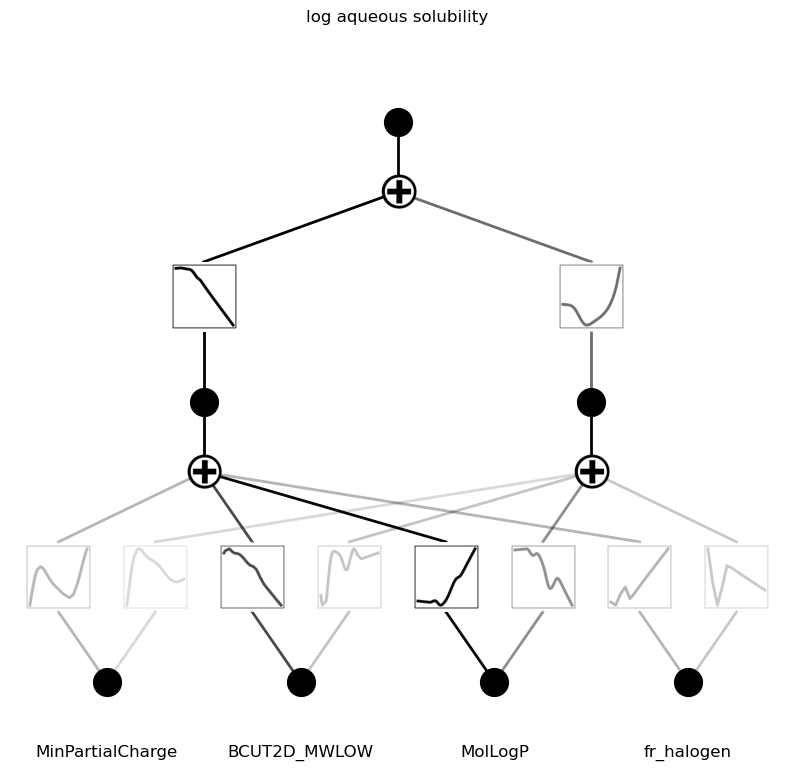

In [316]:
model_fss_2_layer.plot(in_vars=list(features_retained_after_feature_score_selection), varscale=.3, scale=1, out_vars=['log aqueous solubility'])

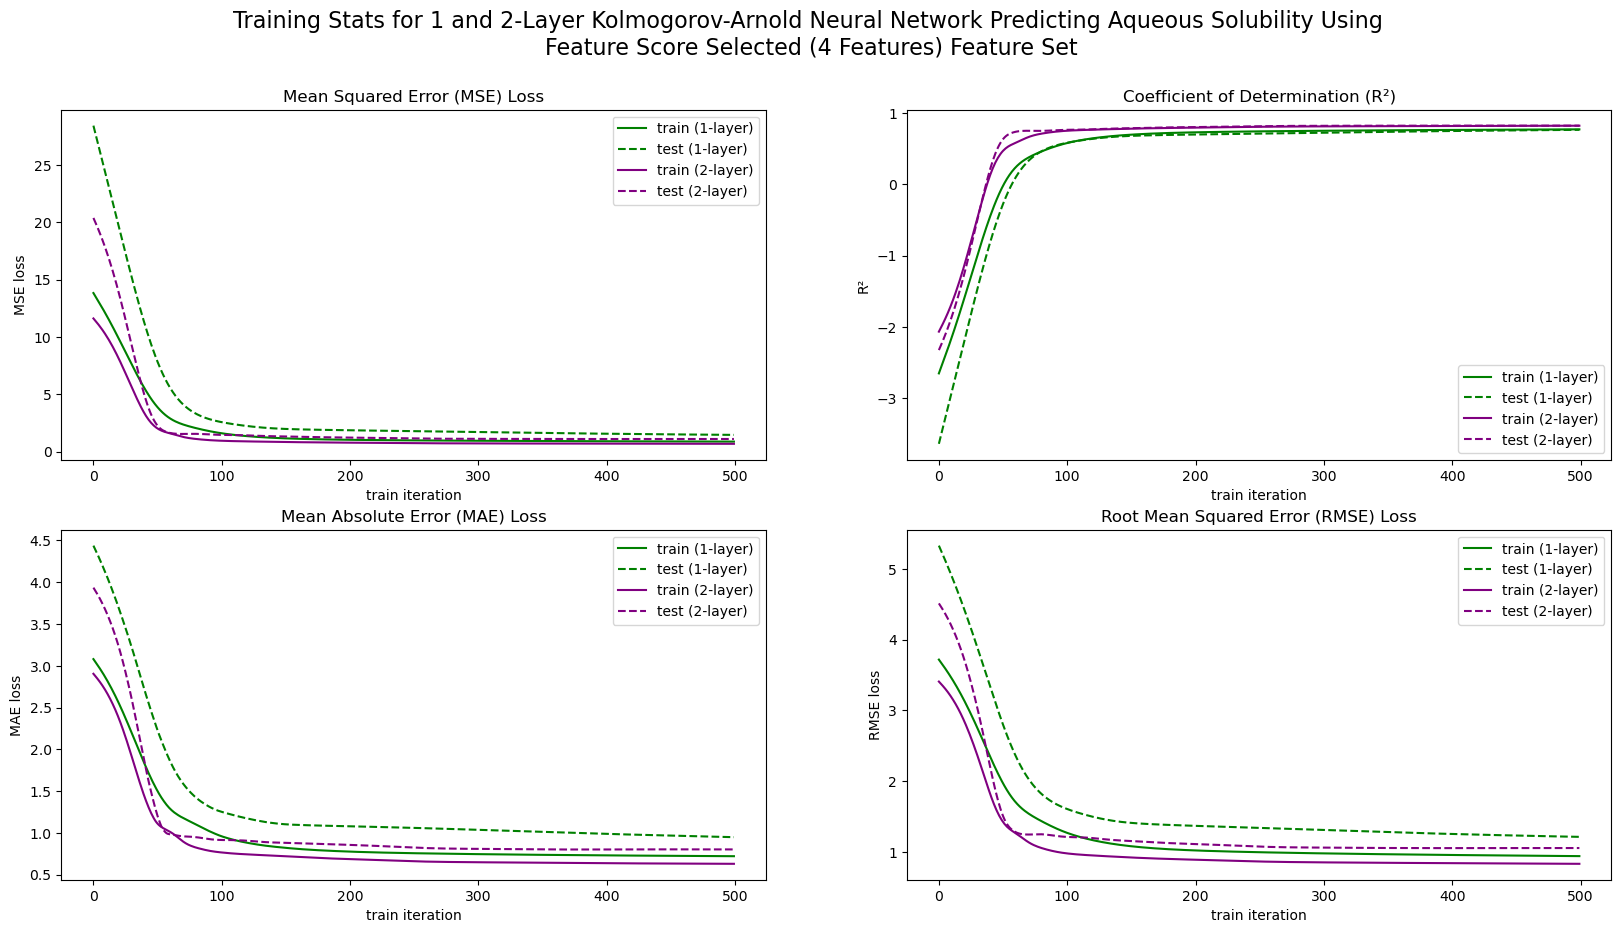

In [317]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for 1 and 2-Layer Kolmogorov-Arnold Neural Network Predicting Aqueous Solubility Using \nFeature Score Selected ({X_train_scaled_feature_score_filtered.shape[1]} Features) Feature Set''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses_fss, c='green', linestyle='-')
ax[0, 0].plot(test_mses_fss, c='green', linestyle='--')
ax[0, 0].plot(train_mses_fss_2_layer, c='purple', linestyle='-')
ax[0, 0].plot(test_mses_fss_2_layer, c='purple', linestyle='--')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train (1-layer)', 'test (1-layer)', 'train (2-layer)', 'test (2-layer)']) 

# r2 plot
ax[0, 1].plot(train_r2s_fss, c='green', linestyle='-')
ax[0, 1].plot(test_r2s_fss, c='green', linestyle='--')
ax[0, 1].plot(train_r2s_fss_2_layer, c='purple', linestyle='-')
ax[0, 1].plot(test_r2s_fss_2_layer, c='purple', linestyle='--')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train (1-layer)', 'test (1-layer)', 'train (2-layer)', 'test (2-layer)']) 

# mae plot
ax[1, 0].plot(train_maes_fss, c='green', linestyle='-')
ax[1, 0].plot(test_maes_fss, c='green', linestyle='--')
ax[1, 0].plot(train_maes_fss_2_layer, c='purple', linestyle='-')
ax[1, 0].plot(test_maes_fss_2_layer, c='purple', linestyle='--')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train (1-layer)', 'test (1-layer)', 'train (2-layer)', 'test (2-layer)']) 

# rmse plot
ax[1, 1].plot(train_rmses_fss, c='green', linestyle='-')
ax[1, 1].plot(test_rmses_fss, c='green', linestyle='--')
ax[1, 1].plot(train_rmses_fss_2_layer, c='purple', linestyle='-')
ax[1, 1].plot(test_rmses_fss_2_layer, c='purple', linestyle='--')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train (1-layer)', 'test (1-layer)', 'train (2-layer)', 'test (2-layer)']) 

plt.show()


# Compare them all

In [318]:
from utils.evaluation_utils import regression_report

In [319]:
models_and_data = {
    f'Full Model ({X_train_scaled.shape[1]} Features)': (full_model, X_train_scaled, y_train, X_test_scaled, y_test),

    f'Reduced; Pearson Corr Coef Filtered ({X_train_scaled_corr_filtered.shape[1]} Features)':
      (model_reduced, X_train_scaled_corr_filtered, y_train, X_test_scaled_corr_filtered, y_test),

    f'1-Layer Feature Score Filtered ({X_train_scaled_feature_score_filtered.shape[1]} Features)': 
    (model_fss, X_train_scaled_feature_score_filtered, y_train, X_test_scaled_feature_score_filtered, y_test),

    f'2-Layer Feature Score Filtered ({X_train_scaled_feature_score_filtered.shape[1]} Features)': 
    (model_fss_2_layer, X_train_scaled_feature_score_filtered, y_train, X_test_scaled_feature_score_filtered, y_test)
}

regression_reports_train = {}
regression_reports_test = {}

for model_name, (model, _X_train, _y_train, _X_test, _y_test) in models_and_data.items():
    y_pred_train = model(_X_train).detach()[:, 0]
    y_pred_test = model(_X_test).detach()[:, 0]

    regression_report_train = regression_report(_y_train, y_pred_train)
    regression_report_test = regression_report(_y_test, y_pred_test) 

    regression_reports_train[model_name] = regression_report_train
    regression_reports_test[model_name] = regression_report_test

regression_reports_train

{'Full Model (196 Features)': {'R2': 0.9694393684386744,
  'MSE': 0.11576495227321965,
  'MAE': 0.25487177474027933,
  'MAPE': 676321489366.8096,
  'RMSE': 0.34024249039944976},
 'Reduced; Pearson Corr Coef Filtered (151 Features)': {'R2': 0.9626835941184942,
  'MSE': 0.14135610833865953,
  'MAE': 0.28458204748346766,
  'MAPE': 468144153238.5819,
  'RMSE': 0.3759735473921796},
 '1-Layer Feature Score Filtered (4 Features)': {'R2': 0.7674228828878791,
  'MSE': 0.881011860252269,
  'MAE': 0.7213997870227916,
  'MAPE': 8983247935549.893,
  'RMSE': 0.9386223203462982},
 '2-Layer Feature Score Filtered (4 Features)': {'R2': 0.8181954672881782,
  'MSE': 0.6886831841221976,
  'MAE': 0.6303941572620038,
  'MAPE': 9215163604469.902,
  'RMSE': 0.8298693777470028}}

In [320]:
train_reports_df = pd.DataFrame(regression_reports_train)

train_reports_df = train_reports_df.reset_index(names='Metric')

train_reports_df['train_or_test'] = 'Train'

test_reports_df = pd.DataFrame(regression_reports_test)

test_reports_df = test_reports_df.reset_index(names='Metric')

test_reports_df['train_or_test'] = 'Test'

reports_df = pd.concat([train_reports_df, test_reports_df], axis=0)

reports_df

,Metric,Full Model (196 Features),Reduced; Pearson Corr Coef Filtered (151 Features),1-Layer Feature Score Filtered (4 Features),2-Layer Feature Score Filtered (4 Features),train_or_test
0,R2,9.694394e-01,9.626836e-01,7.674229e-01,8.181955e-01,Train
1,MSE,1.157650e-01,1.413561e-01,8.810119e-01,6.886832e-01,Train
2,MAE,2.548718e-01,2.845820e-01,7.213998e-01,6.303942e-01,Train
3,MAPE,6.763215e+11,4.681442e+11,8.983248e+12,9.215164e+12,Train
4,RMSE,3.402425e-01,3.759735e-01,9.386223e-01,8.298694e-01,Train
0,R2,8.861329e-01,8.899975e-01,7.605734e-01,8.190134e-01,Test
1,MSE,6.978752e-01,6.741895e-01,1.467411e+00,1.109240e+00,Test
2,MAE,6.108727e-01,5.965557e-01,9.491571e-01,8.025860e-01,Test
3,MAPE,3.108576e-01,2.860111e-01,8.587757e-01,7.020153e-01,Test
4,RMSE,8.353892e-01,8.210904e-01,1.211367e+00,1.053205e+00,Test


In [321]:
model_names = list(models_and_data.keys())

model_names 

['Full Model (196 Features)',
 'Reduced; Pearson Corr Coef Filtered (151 Features)',
 '1-Layer Feature Score Filtered (4 Features)',
 '2-Layer Feature Score Filtered (4 Features)']

In [322]:
reports_df[(reports_df['Metric'] == 'R2') & (reports_df['train_or_test'] == 'Train')][model_names].values.flatten()

array([0.96943937, 0.96268359, 0.76742288, 0.81819547])

In [323]:
format_float = lambda x: f'{round(x, 2)}'

In [324]:
model_names

['Full Model (196 Features)',
 'Reduced; Pearson Corr Coef Filtered (151 Features)',
 '1-Layer Feature Score Filtered (4 Features)',
 '2-Layer Feature Score Filtered (4 Features)']

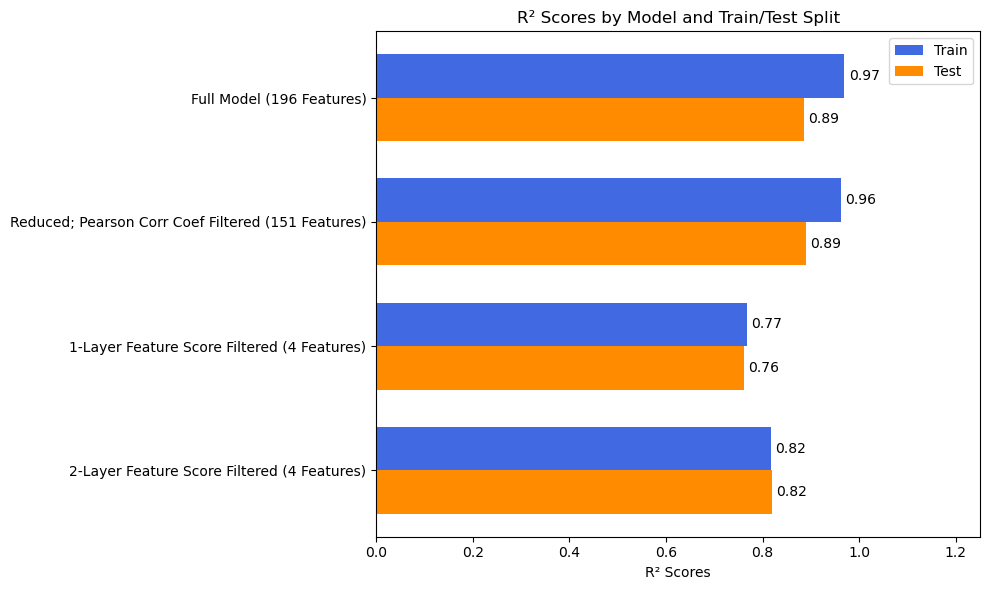

In [325]:
labels = model_names[::-1]
train_metrics = reports_df[(reports_df['Metric'] == 'R2') & (reports_df['train_or_test'] == 'Train')][labels].values.flatten()
test_metrics = reports_df[(reports_df['Metric'] == 'R2') & (reports_df['train_or_test'] == 'Test')][labels].values.flatten()

train_metrics_formatted = [format_float(x) for x in train_metrics]
test_metrics_formatted = [format_float(x) for x in test_metrics]

y = np.arange(len(labels))  # the label locations
height = 0.35  # the height of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

rects1 = ax.barh(y + height/2, train_metrics, height, label='Train', color='royalblue')
rects2 = ax.barh(y - height/2, test_metrics, height, label='Test', color='darkorange')  

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_xlabel('R\u00b2 Scores')
ax.set_title('R\u00b2 Scores by Model and Train/Test Split')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend(handles=[rects1, rects2], labels=['Train', 'Test'])

def autolabel(rects):
    """Attach a text label beside each bar in *rects*, displaying its width."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(format_float(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

ax.set_xlim(0, 1.25)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


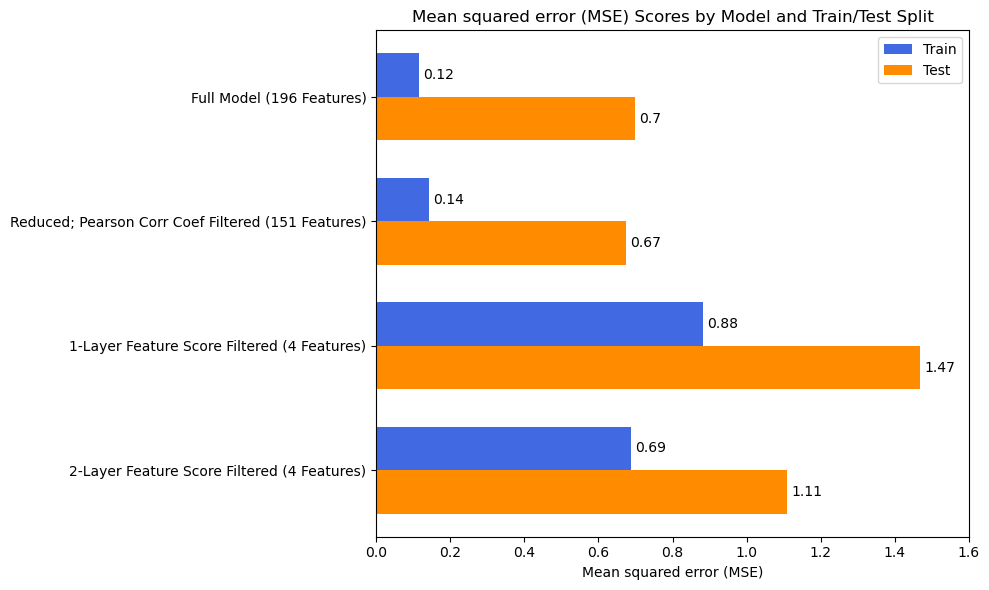

In [329]:
labels = model_names[::-1]
train_metrics = reports_df[(reports_df['Metric'] == 'MSE') & (reports_df['train_or_test'] == 'Train')][labels].values.flatten()
test_metrics = reports_df[(reports_df['Metric'] == 'MSE') & (reports_df['train_or_test'] == 'Test')][labels].values.flatten()

train_metrics_formatted = [format_float(x) for x in train_metrics]
test_metrics_formatted = [format_float(x) for x in test_metrics]

y = np.arange(len(labels))  # the label locations
height = 0.35  # the height of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

rects1 = ax.barh(y + height/2, train_metrics, height, label='Train', color='royalblue')
rects2 = ax.barh(y - height/2, test_metrics, height, label='Test', color='darkorange')  

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_xlabel('Mean squared error (MSE)')
ax.set_title('Mean squared error (MSE) Scores by Model and Train/Test Split')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend(handles=[rects1, rects2], labels=['Train', 'Test'])

def autolabel(rects):
    """Attach a text label beside each bar in *rects*, displaying its width."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(format_float(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

ax.set_xlim(0, 1.6)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()